In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import pathlib

In [2]:
data=pd.read_csv(f"{pathlib.Path().resolve()}\\input\\cnn_dailymail\\train.csv", nrows=100000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  object
 1   article     100000 non-null  object
 2   highlights  100000 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [3]:
data.drop_duplicates(subset=['article'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99637 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          99637 non-null  object
 1   article     99637 non-null  object
 2   highlights  99637 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB


In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString).text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if (num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: # removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
#call the function
cleaned_text = []
for t in data['article']:
    cleaned_text.append(text_cleaner(t,0)) 

In [8]:
#call the function
cleaned_summary = []
for t in data['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [9]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [10]:
#drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

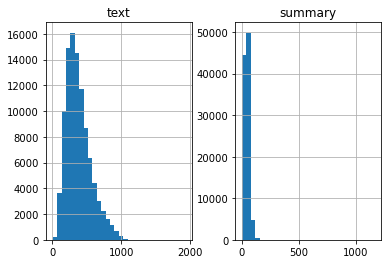

In [11]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [12]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.6828387044973253


In [13]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=700):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9358270521994841


In [14]:
max_text_len=700
max_summary_len=50

In [15]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [16]:
#making sure tokens dont appear in the summaries
for summary in df['summary']:
    if 'sostok' in summary:
        print("ERROR")
    if 'eostok' in summary:
        print("ERROR")

In [17]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 54.67126228834927
Total Coverage of rare words: 0.8275629913951933


In [21]:
#prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [22]:
x_voc

87194

In [23]:
#prepare a tokenizer for headlines on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [24]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 70.4966454907083
Total Coverage of rare words: 3.799591105143823


In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [26]:
y_voc

19878

In [27]:
y_tokenizer.word_counts['sostok'], len(y_tr)

(58500, 58500)

In [28]:
#delete rows that only have start and end tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr, ind, axis=0)
x_tr=np.delete(x_tr, ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [30]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [31]:
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


## Model

In [32]:
# LSTM
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(None,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [33]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    8719400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 300),  481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [36]:
history=model.fit([x_tr, y_tr[:,:-1]],
                   y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                   epochs=20,
                   callbacks=[es],
                   batch_size=128,
                   validation_data=([x_val,
                                     y_val[:,:-1]],
                                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
                                     )
                   )

Epoch 1/20
458/458 [==============================] - 409s 880ms/step - loss: 5.4336 - val_loss: 5.1497
Epoch 2/20
458/458 [==============================] - 403s 881ms/step - loss: 4.9524 - val_loss: 4.8656
Epoch 3/20
458/458 [==============================] - 404s 882ms/step - loss: 4.7069 - val_loss: 4.6825
Epoch 4/20
458/458 [==============================] - 402s 878ms/step - loss: 4.5730 - val_loss: 4.5863
Epoch 5/20
458/458 [==============================] - 404s 881ms/step - loss: 4.4689 - val_loss: 4.5042
Epoch 6/20
458/458 [==============================] - 403s 881ms/step - loss: 4.3825 - val_loss: 4.4486
Epoch 7/20
458/458 [==============================] - 403s 881ms/step - loss: 4.3173 - val_loss: 4.4011
Epoch 8/20
458/458 [==============================] - 403s 880ms/step - loss: 4.2510 - val_loss: 4.3810
Epoch 9/20
458/458 [==============================] - 403s 881ms/step - loss: 4.2057 - val_loss: 4.4452
Epoch 10/20
458/458 [==============================] - 403s 880m

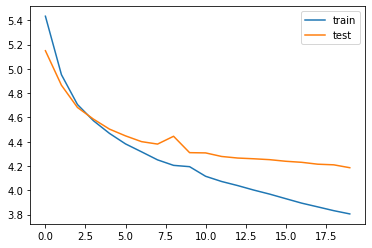

In [37]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
model.save('model//cnn')

INFO:tensorflow:Assets written to: model//cnn\assets


INFO:tensorflow:Assets written to: model//cnn\assets


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model//cnn')

In [38]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference Decoder

In [39]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [41]:
#bidirectional
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [45]:
import pickle 
# Save the tokenizer
with open('LSTM3model/x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('LSTM3model/y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save the weights individually
for layer in model.layers:
    
    weights = layer.get_weights()
    if weights != []:
        np.savez(f'LSTM3model/{layer.name}.npz', weights)

In [43]:
for i in range(0,10):
    print("Article:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Article: conventional way breaking protests sam skateboarding dog certainly seems effective ukrainian police found secret weapon battle demonstrations city odessa form skateboarding british bulldog performing pup already managed work magic one group demonstrators descended city hall duma square south western ukrainian city sam skateboarding dog caused stir ploughed crowds duma square odessa british bulldog proved hit crowds performed tricks board angry mob gathered protest corruption particular relation building permits handed allegedly bribes angry mob waving placards chanting three officers security outside looks things get hand mob started gathering door building looked wanted get inside anger turned amusement laughter mob faded away skateboarder sam swept square started nipping masses skateboard dog even managed break protest demonstrators started laugh pranks ukrainian police could certainly use dog unusual method crowd control protests instantly crowd focused attention dog perfor

Predicted summary:  nasa says it is the first time to be able to land the space station in space station is the first time to the space station in the space station the space station is currently on the ground for the first time since


Article: nigeria president declared state emergency parts country afflicted violence militant islamist group boko haram become imperative take decisive measures necessary restore normalcy country especially within affected communities president goodluck jonathan said saturday address order includes closure country borders affected areas last two months seen widespread bloodshed northern nigeria churches police stations among targets boko haram claimed responsibility series attacks churches central northern nigeria christmas day including one near capital abuja killed nearly people two days later bomb attack islamic school madrassa southern delta state injured several children clear whether intended revenge sectarian attacks rare delta state jonathan sai

Predicted summary:  the uk is the first time to be in the uk since the uk is now in the uk for the first time since the uk is now being held in the uk


Article: two former navy seals among four americans killed last week attack consulate benghazi libya died rushing aid colleagues according sources familiar incident glen doherty tyrone woods benghazi part security contractor force september ensconced safety annex location another part city got word main consulate building fire diplomats armed force nine people overwhelmed deteriorating situation doherty woods along security personnel left secure annex made way chaotic scene rounding consulate staff attack guiding back second safe building grim task also included recovering body computer expert sean smith succumbed smoke inhalation fire ignited attackers sources said diesel fuel used set fire thick black smoke created accelerant added confusion ground ambassador chris stevens gone missing attack among evacuated later reported dead state

Predicted summary:  the duchess of cambridge was found in the morning of the girl family home in the north london and was handed to the house in south london




### Bidirectional Results
The cells are out of order because I ran it and then rearranged the cells

In [34]:
# Bidirectional LSTM
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(None,))

# embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True, name = "enc_embedding")(encoder_inputs)

encoder_lstm1 = Bidirectional(
    LSTM(latent_dim, return_state=True,dropout=0.4,recurrent_dropout=0),
    name = 'encoder_lstm1')
encoder_outputs, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c  = encoder_lstm1(enc_emb)

state_h = Concatenate()([enc_forward_h, enc_backward_h])
state_c = Concatenate()([enc_forward_c, enc_backward_c])
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True, name = 'dec_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
decoder_outputs1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs1, encoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs1, attn_out])

#dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [38]:
history=model.fit([x_tr, y_tr[:,:-1]],
                   y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                   epochs=20,
                   callbacks=[es],
                   batch_size=128,
                   validation_data=([x_val,
                                     y_val[:,:-1]],
                                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
                                     )
                   )

Epoch 1/20
458/458 [==============================] - 384s 810ms/step - loss: 5.4144 - val_loss: 5.0887
Epoch 2/20
458/458 [==============================] - 364s 795ms/step - loss: 4.8844 - val_loss: 4.7562
Epoch 3/20
458/458 [==============================] - 362s 790ms/step - loss: 4.6502 - val_loss: 4.6087
Epoch 4/20
458/458 [==============================] - 343s 748ms/step - loss: 4.5019 - val_loss: 4.5208
Epoch 5/20
458/458 [==============================] - 343s 750ms/step - loss: 4.3849 - val_loss: 4.4533
Epoch 6/20
458/458 [==============================] - 343s 749ms/step - loss: 4.2899 - val_loss: 4.3999
Epoch 7/20
458/458 [==============================] - 343s 749ms/step - loss: 4.2073 - val_loss: 4.3700
Epoch 8/20
458/458 [==============================] - 343s 749ms/step - loss: 4.1317 - val_loss: 4.3351
Epoch 9/20
458/458 [==============================] - 344s 750ms/step - loss: 4.0634 - val_loss: 4.3067
Epoch 10/20
458/458 [==============================] - 343s 748m

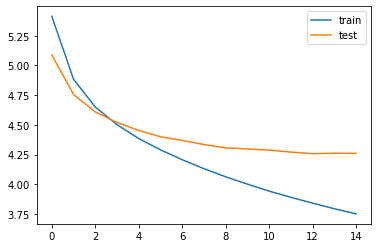

In [45]:
# bidirectional
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
#bidirectional
for i in range(0,10):
    print("Article:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Article: conventional way breaking protests sam skateboarding dog certainly seems effective ukrainian police found secret weapon battle demonstrations city odessa form skateboarding british bulldog performing pup already managed work magic one group demonstrators descended city hall duma square south western ukrainian city sam skateboarding dog caused stir ploughed crowds duma square odessa british bulldog proved hit crowds performed tricks board angry mob gathered protest corruption particular relation building permits handed allegedly bribes angry mob waving placards chanting three officers security outside looks things get hand mob started gathering door building looked wanted get inside anger turned amusement laughter mob faded away skateboarder sam swept square started nipping masses skateboard dog even managed break protest demonstrators started laugh pranks ukrainian police could certainly use dog unusual method crowd control protests instantly crowd focused attention dog perfor

Predicted summary:  the man was pictured on camera in the river river station in the north east of the island of the year old was captured by nasa photographer in the space station the station was on the market for the first time since the moon was released


Article: nigeria president declared state emergency parts country afflicted violence militant islamist group boko haram become imperative take decisive measures necessary restore normalcy country especially within affected communities president goodluck jonathan said saturday address order includes closure country borders affected areas last two months seen widespread bloodshed northern nigeria churches police stations among targets boko haram claimed responsibility series attacks churches central northern nigeria christmas day including one near capital abuja killed nearly people two days later bomb attack islamic school madrassa southern delta state injured several children clear whether intended revenge sectarian attacks rare d

Predicted summary:  dr david said he would not be able to leave the nhs because of patients he says he is not enough to see the drugs as they are not enough to be


Article: two former navy seals among four americans killed last week attack consulate benghazi libya died rushing aid colleagues according sources familiar incident glen doherty tyrone woods benghazi part security contractor force september ensconced safety annex location another part city got word main consulate building fire diplomats armed force nine people overwhelmed deteriorating situation doherty woods along security personnel left secure annex made way chaotic scene rounding consulate staff attack guiding back second safe building grim task also included recovering body computer expert sean smith succumbed smoke inhalation fire ignited attackers sources said diesel fuel used set fire thick black smoke created accelerant added confusion ground ambassador chris stevens gone missing attack among evacuated later reporte

Predicted summary:  the year old was born in the couple in the year old girl who was born in the village of her mother and sister she has been named as the couple of the year old


